In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
# import tensorflow_datasets as tfds
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB1
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import CSVLogger
# import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import os
import keras
from tensorflow.keras.utils import plot_model
# import visualkeras
import pickle
from sklearn.model_selection import KFold

from sklearn.metrics import f1_score, precision_score
from tensorflow.keras.callbacks import Callback

In [27]:
import tensorflow as tf

# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available")
    # Additional GPU information~
    for gpu in gpu_available:
        print("GPU details:")
        print(tf.config.experimental.get_device_details(gpu))
else:
    print("GPU is not available")


GPU is available
GPU details:
{'device_name': 'NVIDIA GeForce RTX 4080', 'compute_capability': (8, 9)}


## Load Data

In [28]:
# Define Constants
TRAIN_PATH = 'Z:\DFU_Kaggle\DFU\Patches'
TEST_PATH = 'Z:\DFU_Kaggle\DFU\TestSet'

BATCH_SIZE = 32
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
NUM_CLASSES = 2
EPOCHS = 200

In [29]:
# Load the Training and Validation Dataset
train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    subset = 'training',
    seed = 0
)

validation_ds = image_dataset_from_directory(
    TRAIN_PATH,
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    subset = 'validation',
    seed = 0
)

# test_ds = image_dataset_from_directory(
#     TEST_PATH,
#     labels = 'inferred',
#     batch_size = BATCH_SIZE,
#     image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
#     seed = 0
# )

Found 1055 files belonging to 2 classes.
Using 844 files for training.
Found 1055 files belonging to 2 classes.
Using 211 files for validation.


In [30]:
# Load Test Dataset
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

test_ds = tf.data.Dataset.list_files(str(TEST_PATH + '/*'), shuffle=True)
# test_ds = test_ds.shuffle(len(os.listdir(TEST_PATH)), reshuffle_each_iteration=True)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [31]:
# Get the class names
class_names = train_ds.class_names
print(class_names)

['Abnormal(Ulcer)', 'Normal(Healthy skin)']


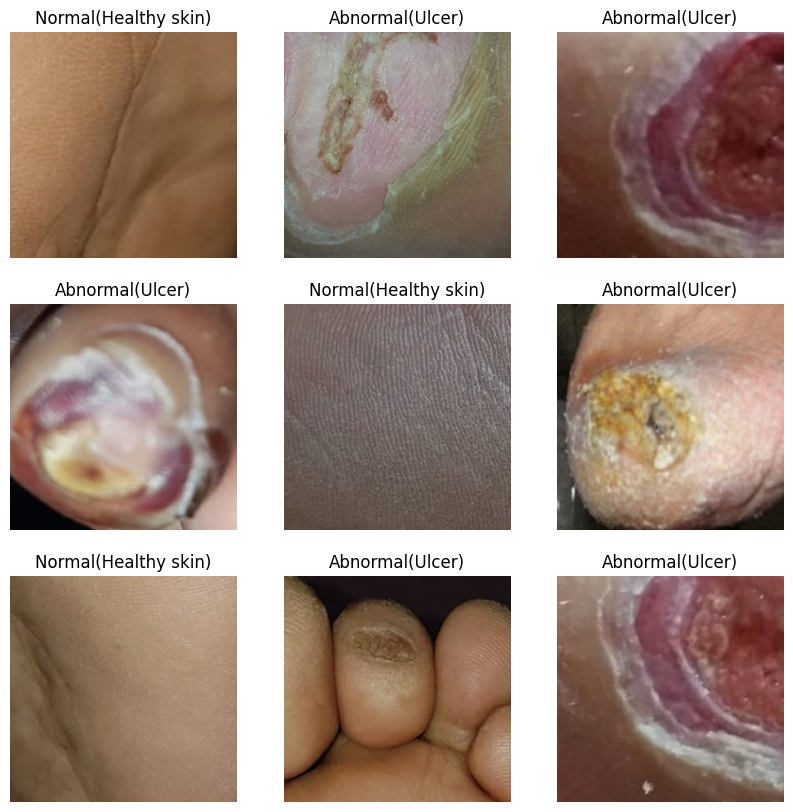

In [9]:
# Visualize the training dataset
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

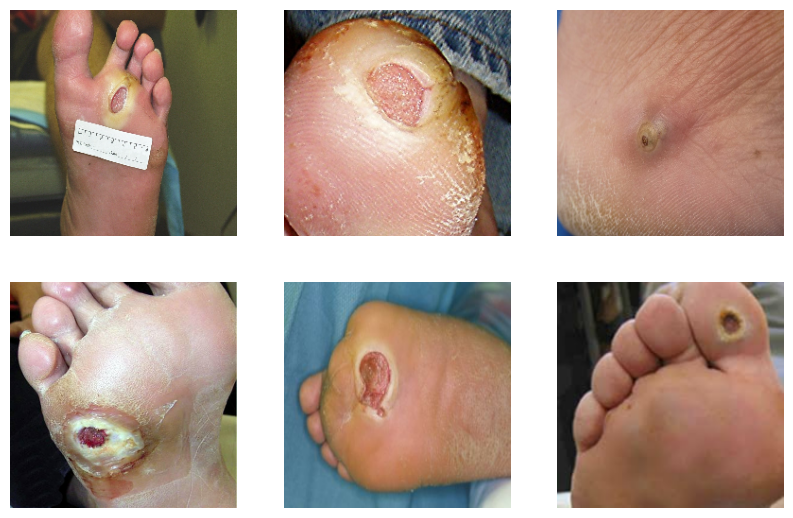

In [10]:
# Visualize the testing dataset
plt.figure(figsize = (10, 10))

i = 0
for images in test_ds.take(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.axis("off")
    i += 1

## Data Augmentation

In [32]:
# Layers of Augmentation
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor = 0.15),
        layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        layers.RandomFlip(),
        layers.GaussianNoise(stddev = 0.09),
        layers.RandomContrast(factor = 0.1),
    ],
    name = "img_augmentation"
)


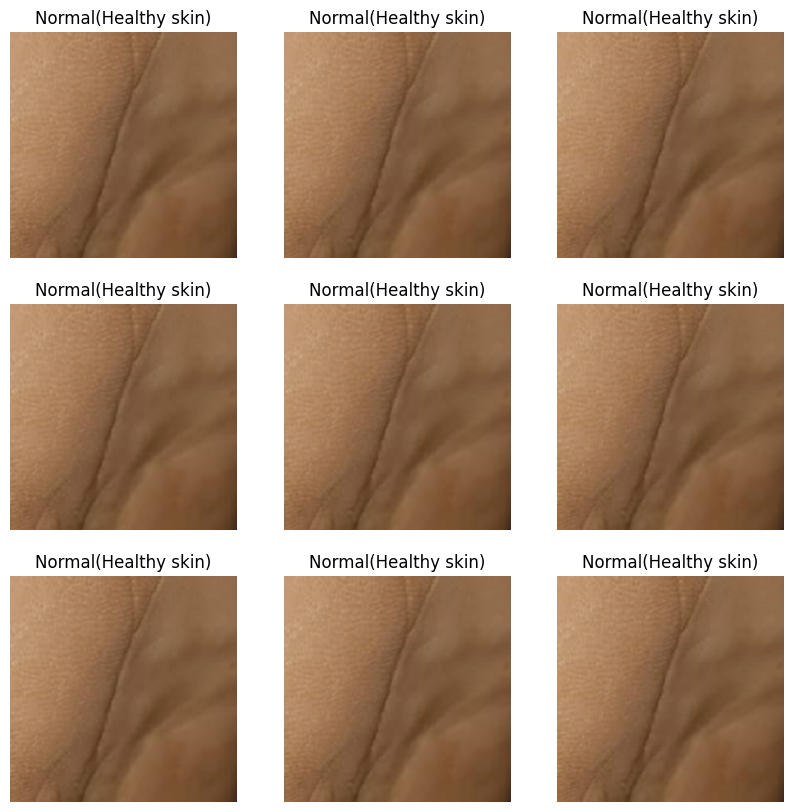

In [33]:
# View the augmentations
plt.figure(figsize = (10, 10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis = 0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [66]:
# Caching and Prefetching (Optimization)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [67]:
# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8)
# metrics_callback = MetricsCallback(validation_data=validation_ds)

In [71]:
def img_augmentation(inputs):
    x = layers.Rescaling(1./255)(inputs)  # Normalize images
    x = layers.RandomFlip("horizontal")(x)  # Random horizontal flip
    x = layers.RandomRotation(0.15)(x)  # Random rotation
    x = layers.RandomTranslation(height_factor=0.1, width_factor=0.1)(x)  # Random translation
    x = layers.GaussianNoise(stddev=0.09)(x)  # Gaussian noise
    x = layers.RandomContrast(factor=0.1)(x)  # Random contrast adjustment
    return x

# Initialize Model
def build_model():
    inputs = layers.Input(shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    x = img_augmentation(inputs)
    
    model = EfficientNetB1(include_top = False, weights = "imagenet", input_tensor = x)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation = "sigmoid", name = "pred")(x)
    
    # Compile
    # model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = optimizers.Adam(learning_rate=1e-2)
    # optimizer = optimizers.SGD(learning_rate=1e-2)
    # loss = losses.SparseCategoricalCrossentropy()
    loss=losses.BinaryCrossentropy()
    model.compile(
        optimizer=optimizer, loss=loss, metrics=["accuracy"]
    )
    
    # model.summary() 
    
    return model


In [72]:
model = build_model()

In [73]:
    history = model.fit(train_ds, validation_data = validation_ds, 
                    callbacks = [lr_callback, stop_callback],
                    epochs = 40, verbose = 1)

Epoch 1/40


InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\DBE.DESKTOP-H51H16P\AppData\Local\Temp\ipykernel_25740\120638904.py", line 1, in <module>
      history = model.fit(train_ds, validation_data = validation_ds,
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\engine\training.py", line 894, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\engine\training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\engine\compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\metrics\base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\metrics\base_metric.py", line 646, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\metrics\metrics.py", line 3327, in sparse_categorical_accuracy
      matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "C:\Users\DBE.DESKTOP-H51H16P\miniconda3\envs\DFU\lib\site-packages\keras\utils\metrics_utils.py", line 893, in sparse_categorical_matches
      matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal'
required broadcastable shapes
	 [[{{node Equal}}]] [Op:__inference_train_function_324593]

In [64]:
# Example of converting labels
def preprocess_labels(labels):
    return tf.cast(labels, tf.float32)  # Convert labels to float32 if needed


In [65]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    image = img_augmentation(image)  # Apply augmentations
    label = tf.cast(label, tf.float32)  # Ensure labels are float32 for binary classification
    return image, label

train_ds = train_ds.map(preprocess_image)
validation_ds = validation_ds.map(preprocess_image)
